# **Desarrollo de Modelo IA para prevenir perdidas -> NN LSTM**
# By: S&S Investments

## Creación del entorno (Importación Librerias)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

## Cargar Dataframe a traves de un solo archivo

In [2]:
def load_pandas_dataframe(path:str)->pd.DataFrame:
    try:
        df = pd.read_csv(path,  sep=",")
        return df
    except FileNotFoundError:
        print(f"Error: The file '{path}' was not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{path}' is empty.")
        return None
    except pd.errors.ParserError:
        print(f"Error: There was a problem parsing the file '{path}'.")
        return None
    except UnicodeDecodeError:
        print(f"Error: The file '{path}' has an encoding issue.")
        return None
    except ValueError as ve:
        print(f"ValueError: {ve}")
        return None
    except TypeError as te:
        print(f"TypeError: {te}")
        return None
    except IsADirectoryError:
        print(f"Error: '{path}' is a directory, not a file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None
    
def create_dataframe_one_file(path:str):
    df_history = load_pandas_dataframe(path)
    #Ordenar dataframe por la fecha
    df_history_ordered = df_history.sort_values('Time')
    return df_history_ordered

df_history_ordered = create_dataframe_one_file("Resources/history_SP3_DEMA800_30M_3Y.csv") #Usar historia de 3 años
df_history_ordered.head(5)

,Time,Symbol,Open,High,Low,Close,Volume,Supertrend,Polaridad,DEMA800,Half-Order,Profit,Stoploss-Reached,Exit-Price,ATR,ADX,P&L
0,2021-10-24 03:00:00-05:00,XRPUSDT,1.0848,1.0860,1.0831,1.0842,1473773.0,1.093251,Sell,1.130686,True,False,False,1.084200,0.003242,20.870454,0.0294
1214,2021-10-24 06:30:00-05:00,DOTUSDT,43.3150,43.3450,42.4850,42.5950,103502.6,44.030335,Sell,45.024116,False,False,True,44.030335,0.330754,15.977562,-1.4080
1215,2021-10-26 09:00:00-05:00,DOTUSDT,44.0950,44.1050,43.3050,43.6300,67713.6,44.732323,Sell,45.379222,False,False,True,44.732323,0.302189,14.459867,-0.8080
1,2021-10-26 09:00:00-05:00,XRPUSDT,1.1121,1.1123,1.0950,1.1008,10803134.0,1.124411,Sell,1.123274,False,False,True,1.124411,0.006311,23.326970,-0.2142
1216,2021-10-26 17:30:00-05:00,DOTUSDT,45.2050,45.2050,43.6450,44.3450,115117.2,46.551982,Sell,45.498452,True,True,False,42.470000,0.540539,25.676744,1.6680


## Craer flujo de trasnformaciones para normalizar y adaptar dataframe a estandares de entrenamiento

In [3]:
import pandas as pd

def clean_data(df_history_ordered):
    # One-hot encode columns: 'Symbol', 'Polaridad'
    for column in ['Symbol', 'Polaridad']:
        insert_loc = df_history_ordered.columns.get_loc(column)
        df_history_ordered = pd.concat([df_history_ordered.iloc[:,:insert_loc], pd.get_dummies(df_history_ordered.loc[:, [column]]), df_history_ordered.iloc[:,insert_loc+1:]], axis=1)
    # Scale columns 'Open', 'High' and 8 other columns between 0 and 1
    new_min, new_max = 0, 1
    old_min, old_max = df_history_ordered['Open'].min(), df_history_ordered['Open'].max()
    df_history_ordered['Open'] = (df_history_ordered['Open'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['High'].min(), df_history_ordered['High'].max()
    df_history_ordered['High'] = (df_history_ordered['High'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['Low'].min(), df_history_ordered['Low'].max()
    df_history_ordered['Low'] = (df_history_ordered['Low'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['Close'].min(), df_history_ordered['Close'].max()
    df_history_ordered['Close'] = (df_history_ordered['Close'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['Volume'].min(), df_history_ordered['Volume'].max()
    df_history_ordered['Volume'] = (df_history_ordered['Volume'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['Supertrend'].min(), df_history_ordered['Supertrend'].max()
    df_history_ordered['Supertrend'] = (df_history_ordered['Supertrend'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['DEMA800'].min(), df_history_ordered['DEMA800'].max()
    df_history_ordered['DEMA800'] = (df_history_ordered['DEMA800'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['Exit-Price'].min(), df_history_ordered['Exit-Price'].max()
    df_history_ordered['Exit-Price'] = (df_history_ordered['Exit-Price'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['ATR'].min(), df_history_ordered['ATR'].max()
    df_history_ordered['ATR'] = (df_history_ordered['ATR'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    old_min, old_max = df_history_ordered['ADX'].min(), df_history_ordered['ADX'].max()
    df_history_ordered['ADX'] = (df_history_ordered['ADX'] - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    return df_history_ordered

df_history_ordered_clean = clean_data(df_history_ordered.copy())
df_history_ordered_clean.head()

,Time,Symbol_DOTUSDT,Symbol_ONEUSDT,Symbol_XRPUSDT,Open,High,Low,Close,Volume,Supertrend,Polaridad_Buy,Polaridad_Sell,DEMA800,Half-Order,Profit,Stoploss-Reached,Exit-Price,ATR,ADX,P&L
0,2021-10-24 03:00:00-05:00,False,False,True,0.020452,0.020121,0.020603,0.020146,0.004309,0.020361,False,True,0.021078,True,False,False,0.020248,0.003693,0.259307,0.0294
1214,2021-10-24 06:30:00-05:00,True,False,False,0.823214,0.809550,0.814638,0.797850,0.000300,0.826610,False,True,0.845941,False,False,True,0.828902,0.380579,0.152603,-1.4080
1215,2021-10-26 09:00:00-05:00,True,False,False,0.838042,0.823747,0.830364,0.817240,0.000196,0.839792,False,True,0.852614,False,False,True,0.842120,0.347707,0.119505,-0.8080
1,2021-10-26 09:00:00-05:00,False,False,True,0.020971,0.020612,0.020831,0.020457,0.031598,0.020946,False,True,0.020938,False,False,True,0.021005,0.007224,0.312878,-0.2142
1216,2021-10-26 17:30:00-05:00,True,False,False,0.859142,0.844296,0.836885,0.830636,0.000334,0.873960,False,True,0.854855,True,True,False,0.799522,0.621990,0.364122,1.6680


## Hacer separación del Dataframe principal a varios sub Dataframes por tiempo

In [4]:
from sklearn.model_selection import train_test_split
#Filtrar datos desde el 2022 hacia adelante
df_history_ordered_clean_train = df_history_ordered_clean[df_history_ordered_clean['Time'] >= '2022-01-01']

#Crear X_train, y_train, X_test, y_test

X = df_history_ordered_clean_train[['Time','Symbol_DOTUSDT','Symbol_ONEUSDT','Symbol_XRPUSDT','Open','High',
                                    'Low','Close','Volume','Supertrend','Polaridad_Buy','Polaridad_Sell',
                                    'DEMA800','ATR', 'ADX']]
y = df_history_ordered_clean_train['Stoploss-Reached']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"X_train, {X_train.shape}")
print(f"y_train, {y_train.shape}")
print(f"X_test, {X_test.shape}")
print(f"y_test, {y_test.shape}")


X_train, (1201, 15)
y_train, (1201,)
X_test, (516, 15)
y_test, (516,)


## Construir Arquitecturas LSTM 

### Función para construir secuencias

In [5]:

def ta_sma(source, length, rounded=7) -> float:

    sum_length = sum(source)
    SMA = round(sum_length/length, rounded)

    return SMA


def ta_ema(source: pd.Series, length: int, rounded=7, ):

    alpha = 2 / (length + 1)

    SMA = []
    EMA = []

    aux = 0
    prev_ema = 0

    for close_price in source:

        aux = aux + 1

        if (aux < length):
            SMA.append(close_price)
            EMA.append(None)
            continue

        elif (aux == length):
            prev_ema = ta_sma(SMA, length)
            EMA.append(prev_ema)
            continue

        elif (aux > length):
            close_price = round(close_price, rounded)
            prev_ema = round(
                (alpha * close_price + (1 - alpha) * prev_ema), rounded)
            EMA.append(prev_ema)

    return EMA


def ta_second_ema(source, length, rounded=7):

    alpha = 2 / (length + 1)

    SMA = []
    EMA2 = []

    aux = 0
    prev_ema2 = 0

    for ema_value in source:

        if (ema_value == None):
            EMA2.append(None)
            continue

        elif (ema_value != None):

            aux = aux + 1

            if (aux < length):
                SMA.append(ema_value)
                EMA2.append(None)
                continue

            elif (aux == length):
                prev_ema2 = ta_sma(SMA, length)
                EMA2.append(prev_ema2)
                continue

            elif (aux > length):
                prev_ema2 = round(
                    (alpha * ema_value + (1 - alpha) * prev_ema2), rounded)
                EMA2.append(prev_ema2)

    return EMA2

def dema(df: pd.DataFrame, length: int = 800, rounded=7):

    src = df['Close']

    e1 = ta_ema(src, length)
    e2 = ta_second_ema(e1, length)

    dema = []

    for a, b in zip(e1, e2):

        if a is None or b is None:
            dema.append(None)

        else:
            result = round(2 * a - b, rounded)
            dema.append(result)

    return dema


def update_df(data: pd.DataFrame, test_length: int = 800):

    kline = data.iloc[::-1].reset_index(drop=True)

    _ema = ta_ema(kline['Close'], test_length)
    _dema = dema(kline, test_length)

    kline["EMA"] = _ema
    kline["DEMA800"] = _dema

    FULL_original_order_kline = kline.iloc[::-1].reset_index(drop=True)

    return FULL_original_order_kline

In [6]:
import requests
import pytz
import pandas_ta as ta
from datetime import datetime

def create_window_sequence(num_reg:int, train_orders:pd.DataFrame, target_train:pd.DataFrame):
    ret_X, ret_y = [], []
    for i in range(len(X_train)):
        print(f"Procesando registro {i+1}...")
        X_window, y_window = [], []
        reg_time = int(datetime.fromisoformat(X_train.iloc[i]["Time"]).timestamp() * 1000)
        if X_train.iloc[i]["Symbol_XRPUSDT"]:
            symbol = "XRPUSDT"
            append_symb_list = [1,0,0]
        elif X_train.iloc[i]["Symbol_ONEUSDT"]:
            symbol = "ONEUSDT"
            append_symb_list = [0,1,0]
        elif X_train.iloc[i]["Symbol_DOTUSDT"]:
            symbol = "DOTUSDT"
            append_symb_list = [0,0,1]
        else:
            print("Orden no ejecutada correctamente")
            break
        target_val = target_train.iloc[i]
        df = get_historical_data(reg_time,symbol,"30")
        df = CalculateSupertrend(df)
        if num_reg <= len(df):
            df_slice = df.iloc[:num_reg]
            df_reversed = df_slice.iloc[::-1].reset_index(drop=True)
            for j in range(len(df_reversed)):
                values = df_reversed.iloc[j][['Open', 'High', 'Low', 'Close', 'Volume', 'Supertrend', 
                                            'Polaridad', 'DEMA800', 'ATRr_14', 'ADX_14']].values
                symbol_arr = np.array(append_symb_list)
                X_window.append(np.concatenate((values, symbol_arr)))
                y_window.append(target_val)
            ret_X.append(np.array(X_window))
            ret_y.append(np.array(y_window))
        else:
            print("Longitud del muestreo invalida")
            break
    if len(ret_X) > 0 and len(ret_X) == len(ret_y):
        return ret_X, ret_y
    else:
        return None, None

def get_historical_data(reg_time:int, symbol:str, interval: str)->pd.DataFrame:
    list_registers = []
    unix_endtime = None
    for i in range(0, 3):
        if i == 0:  # Primer llamado: Historial de mercado con tiempo actual
            url = 'http://api.bybit.com/v5/market/kline?symbol='+symbol + \
                '&interval='+interval+'&limit=' + \
                str(1000)+'&end='+str(reg_time)
            while (True):
                try:
                    data = requests.get(url).json()
                    unix_endtime = data['result']["list"][-1][0]
                    break
                except requests.exceptions.ConnectionError as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
                except requests.RequestException as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
                except Exception as e:
                    print(
                        f"An error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
        if i == 1 and unix_endtime != None:
            url = 'http://api.bybit.com/v5/market/kline?symbol='+symbol + \
                '&interval='+interval+'&limit=' + \
                str(1000)+'&end='+str(unix_endtime)
            while (True):
                try:
                    data = requests.get(url).json()
                    unix_endtime = data['result']["list"][-1][0]
                    break
                except requests.exceptions.ConnectionError as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
                except requests.RequestException as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
        if i == 2 and unix_endtime != None:
            url = 'http://api.bybit.com/v5/market/kline?symbol='+symbol + \
                '&interval='+interval+'&limit=' + \
                str(200)+'&end='+str(unix_endtime)
            while (True):
                try:
                    data = requests.get(url).json()
                    break
                except requests.exceptions.ConnectionError as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
                except requests.RequestException as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
        # Crear proto dataframe y añadir a lista
        df = pd.DataFrame(data['result']["list"], columns=[
                          'Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Turnover'])
        df['Time'] = pd.to_numeric(df['Time'])
        df = df.drop_duplicates()
        df['Time'] = df['Time'].apply(
            lambda x: datetime.fromtimestamp(x / 1000, tz=pytz.UTC))
        target_timezone = pytz.timezone('Etc/GMT+5')
        df['Time'] = df['Time'].apply(lambda x: x.astimezone(target_timezone))
        df = df.drop(columns=['Turnover'])
        list_registers.append(df)

    concatenated_df = pd.concat(
        [list_registers[0], list_registers[1], list_registers[2]], axis=0)
    concatenated_df = concatenated_df.reset_index(drop=True)
    float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    concatenated_df[float_columns] = concatenated_df[float_columns].astype(
        float)
    concatenated_df = concatenated_df.drop_duplicates()
    return concatenated_df

def CalculateSupertrend(data: pd.DataFrame):
    mult = 3
    reversed_df = data.iloc[::-1]
    Temp_Trend = ta.supertrend(
        high=reversed_df['High'],
        low=reversed_df['Low'],
        close=reversed_df['Close'],
        period=10,
        multiplier=mult)
    
    ATR = ta.atr(high=reversed_df['High'], low=reversed_df['Low'], close=reversed_df['Close'], length=14)
    ADX = ta.adx(high=reversed_df['High'], low=reversed_df['Low'], close=reversed_df['Close'], length=14)

    Temp_Trend = Temp_Trend.rename(columns={f'SUPERT_7_{mult}.0': 'Supertrend', f'SUPERTd_7_{mult}.0': 'Polaridad',
                                   f'SUPERTl_7_{mult}.0': 'ST_Inferior', f'SUPERTs_7_{mult}.0': 'ST_Superior'})

    df_merge = pd.merge(data, Temp_Trend, left_index=True, right_index=True)
    df_merge = pd.merge(df_merge, ATR, left_index=True, right_index=True)
    df_merge = pd.merge(df_merge, ADX, left_index=True, right_index=True)

    df_merge_ma_final = update_df(df_merge) # Actualizar el dataframe con las medias moviles (EMA , DEMA)
    return df_merge_ma_final

### Construir secuencias

In [7]:
X_train_sequences, y_train_sequences = create_window_sequence(150,X_train, y_train)
print(f"X_train_sequences, {len(X_train_sequences)}")
print(f"y_train_sequences, {len(y_train_sequences)}")
#Transformar a objeto numpy
X_train_sq_np = np.array(X_train_sequences)  
y_train_sq_np = np.array(y_train_sequences)
#Guardar datos en archivos
np.save('Resources/X_train_sq_np_150.npy', X_train_sq_np)
np.save('Resources/y_train_sq_np_150.npy', y_train_sq_np)

Procesando registro 1...
Procesando registro 2...
Procesando registro 3...
Procesando registro 4...
Procesando registro 5...
Procesando registro 6...
Procesando registro 7...
Procesando registro 8...
Procesando registro 9...
Procesando registro 10...
Procesando registro 11...
Procesando registro 12...
Procesando registro 13...
Procesando registro 14...
Procesando registro 15...
Procesando registro 16...
Procesando registro 17...
Procesando registro 18...
Procesando registro 19...
Procesando registro 20...
Procesando registro 21...
Procesando registro 22...
Procesando registro 23...
Procesando registro 24...
Procesando registro 25...
Procesando registro 26...
Procesando registro 27...
Procesando registro 28...
Procesando registro 29...
Procesando registro 30...
Procesando registro 31...
Procesando registro 32...
Procesando registro 33...
Procesando registro 34...
Procesando registro 35...
Procesando registro 36...
Procesando registro 37...
Procesando registro 38...
Procesando registro 3

### Crear Arquitectura de la red basada en secuencia

In [12]:
X_train_sq_np = np.load('Resources/X_train_sq_np_150.npy', allow_pickle=True)
y_train_sq_np = np.load('Resources/y_train_sq_np_150.npy', allow_pickle=True)
y_train_res = np.array([seq[0] for seq in y_train_sq_np], dtype=np.float32) 
X_train_sq_np = np.array(X_train_sq_np, dtype=np.float32)
print(f"X_train_sq_np {X_train_sq_np.shape}")
print(f"y_train_sq_np {y_train_res.shape}")

X_train_sq_np (1201, 150, 13)
y_train_sq_np (1201,)


In [39]:
#Revisar inbalances en la variable Target
print(np.bincount(y_train_res.flatten().astype(int)))  # Check class balance

[685 516]


In [41]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_res.flatten()),
    y=y_train_res.flatten()
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


model = Sequential()

# Añadir capa LSTM con dropout para evitar sobreajustar
model.add(LSTM(units=150, return_sequences=False, input_shape=(150, 13)))  # return_sequences=False retorna un output y no una secuencia
model.add(Dropout(0.2))

# Bloque primera capa densa de 128 neuronas con activación RELU
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

# Bloque segunda capa densa de 256 (Increase) neuronas con activación RELU
model.add(Dense(units=128, activation='relu'))  # Maximas neuronas
model.add(Dropout(0.2))

# Bloque tercera capa densa de 128 (Decrease) neuronas con activación RELU
model.add(Dense(units=64, activation='relu'))  # Minimizar a la mitad
model.add(Dropout(0.2))

# Bloque cuarta capa densa de 64 (Decrease) neuronas con activación RELU
model.add(Dense(units=32, activation='relu'))  # Minimizar a la mitad
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))  # Output binario con activación SIGMOIDE

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/home/santiago/Documentos/S&S_Investments/IA_Explore/EDA_SS_IA/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Arquitectura LSTM Increase - Decrease 1/2 hasta 64 -> Stoploss-Reached

In [43]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 150)            │        98,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        38,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,321 (704.38 KB)

 Trainable params: 180,321 (704.38 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento LSTM Increase - Decrease 1/2 hasta 64 -> Stoploss-Reached

In [44]:
history = model.fit(X_train_sq_np, y_train_res, epochs=100, batch_size=32, validation_split= 0.2, class_weight=class_weight_dict)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.5324 - loss: 0.6885 - val_accuracy: 0.5602 - val_loss: 0.6857
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.5191 - loss: 0.7075 - val_accuracy: 0.4398 - val_loss: 0.7012
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.4845 - loss: 0.6982 - val_accuracy: 0.4398 - val_loss: 0.6951
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.4812 - loss: 0.6976 - val_accuracy: 0.5602 - val_loss: 0.6902
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.5094 - loss: 0.6972 - val_accuracy: 0.5602 - val_loss: 0.6914
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.5208 - loss: 0.6903 - val_accuracy: 0.4440 - val_loss: 0.6933
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.4964 - loss: 0.6912 - val_accuracy: 0.4481 - val_loss: 0.6936
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.4430 - loss: 0.7045 - val_accu

#### Reporte de metricas de entrenamiento

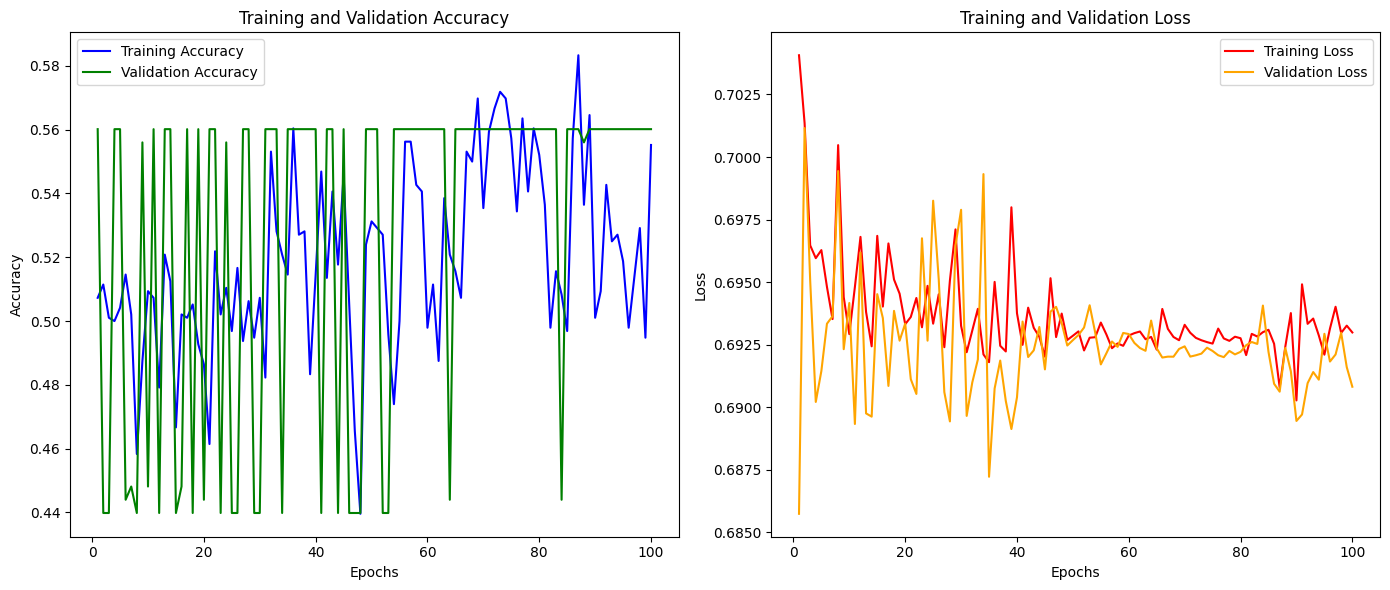

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


# Create subplots
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Arquitectura LSTM Increase - Decrease 1/2 hasta 64 -> Stoploss-Reached ADAM Redux

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


model_redux = Sequential()

# Añadir capa LSTM con dropout para evitar sobreajustar
model_redux.add(LSTM(units=150, return_sequences=False, input_shape=(150, 13)))  # return_sequences=False retorna un output y no una secuencia
model_redux.add(Dropout(0.2))

# Bloque primera capa densa de 128 neuronas con activación RELU
model_redux.add(Dense(units=128, activation='relu'))
model_redux.add(Dropout(0.2))

# Bloque segunda capa densa de 256 (Increase) neuronas con activación RELU
model_redux.add(Dense(units=256, activation='relu'))  # Maximas neuronas
model_redux.add(Dropout(0.2))

# Bloque tercera capa densa de 128 (Decrease) neuronas con activación RELU
model_redux.add(Dense(units=128, activation='relu'))  # Minimizar a la mitad
model_redux.add(Dropout(0.2))

# Bloque cuarta capa densa de 64 (Decrease) neuronas con activación RELU
model_redux.add(Dense(units=64, activation='relu'))  # Minimizar a la mitad
model_redux.add(Dropout(0.2))

model_redux.add(Dense(units=1, activation='sigmoid'))  # Output binario con activación SIGMOIDE

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model_redux.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model_redux.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 150)            │        98,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,969 (749.88 KB)

 Trainable params: 191,969 (749.88 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history_1 = model_redux.fit(X_train_sq_np, y_train_res, epochs=100, batch_size=32, validation_split= 0.2, class_weight=class_weight_dict)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.5275 - loss: 0.6985 - val_accuracy: 0.5602 - val_loss: 0.6913
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.4845 - loss: 0.7071 - val_accuracy: 0.5602 - val_loss: 0.6914
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.5377 - loss: 0.6852 - val_accuracy: 0.5602 - val_loss: 0.6920
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.4839 - loss: 0.7021 - val_accuracy: 0.4398 - val_loss: 0.6936
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.4722 - loss: 0.7038 - val_accuracy: 0.5643 - val_loss: 0.6931
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.4779 - loss: 0.7067 - val_accuracy: 0.4440 - val_loss: 0.6939
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.4836 - loss: 0.6981 - val_accuracy: 0.4440 - val_loss: 0.6932
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.5044 - loss: 0.6954 - val_acc

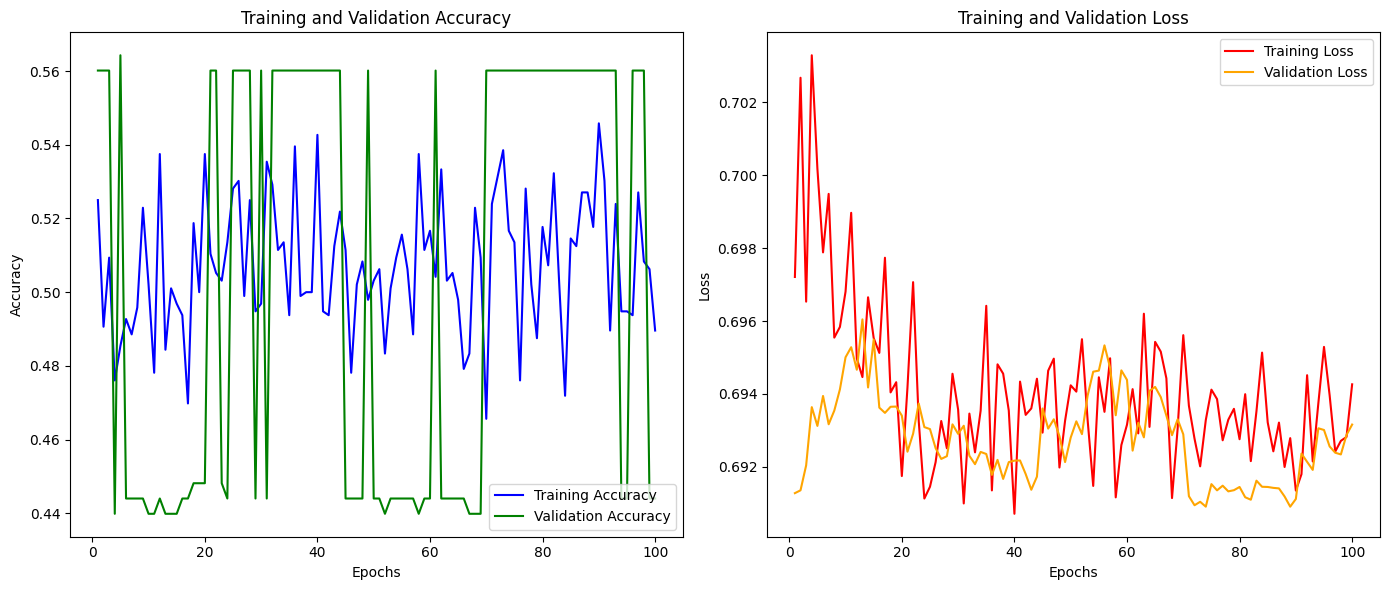

In [49]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(acc) + 1)


# Create subplots
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Arquitectura Complex LSTM Increase - Decrease 1/2 hasta 64 -> Stoploss-Reached ADAM Redux

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


complex_model_redux = Sequential()

# Añadir capa LSTM con dropout para evitar sobreajustar
complex_model_redux.add(LSTM(256, return_sequences=True, input_shape=(150, 13)))  # return_sequences=False retorna un output y no una secuencia
complex_model_redux.add(Dropout(0.3))

# Añadir capa LSTM para complejidad con dropout para evitar sobreajustar
complex_model_redux.add(LSTM(128, return_sequences=True))  # return_sequences=False retorna un output y no una secuencia
complex_model_redux.add(Dropout(0.3))

# Añadir capa LSTM para complejidad con dropout para evitar sobreajustar
complex_model_redux.add(LSTM(64, return_sequences=False))  # return_sequences=False retorna un output y no una secuencia
complex_model_redux.add(Dropout(0.3))


# Bloque primera capa densa de 128 neuronas con activación RELU
complex_model_redux.add(Dense(units=128, activation='relu'))
complex_model_redux.add(Dropout(0.2))

# Bloque cuarta capa densa de 64 (Decrease) neuronas con activación RELU
complex_model_redux.add(Dense(units=64, activation='relu'))  # Minimizar a la mitad
complex_model_redux.add(Dropout(0.2))

# Bloque cuarta capa densa de 32 (Decrease) neuronas con activación RELU
complex_model_redux.add(Dense(units=32, activation='relu'))  # Minimizar a la mitad
complex_model_redux.add(Dropout(0.2))


complex_model_redux.add(Dense(units=1, activation='sigmoid'))  # Output binario con activación SIGMOIDE

# Compile the model
complex_model_redux.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
complex_model_redux.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 150, 256)       │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 150, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,697 (2.07 MB)

 Trainable params: 541,697 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history_2 = complex_model_redux.fit(X_train_sq_np, y_train_res, epochs=100, batch_size=128, validation_split= 0.2, class_weight=class_weight_dict)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5440 - loss: 0.7035 - val_accuracy: 0.4440 - val_loss: 0.6943
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5206 - loss: 0.6973 - val_accuracy: 0.4398 - val_loss: 0.6970
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5045 - loss: 0.6971 - val_accuracy: 0.4398 - val_loss: 0.6962
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4888 - loss: 0.6960 - val_accuracy: 0.4398 - val_loss: 0.6968
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4735 - loss: 0.6998 - val_accuracy: 0.4398 - val_loss: 0.7029
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4718 - loss: 0.7007 - val_accuracy: 0.4398 - val_loss: 0.6962
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5113 - loss: 0.6903 - val_accuracy: 0.5602 - val_loss: 0.6907
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5035 - loss: 0.6961 - val_accuracy: 0.5560 - val_loss: 0.6931


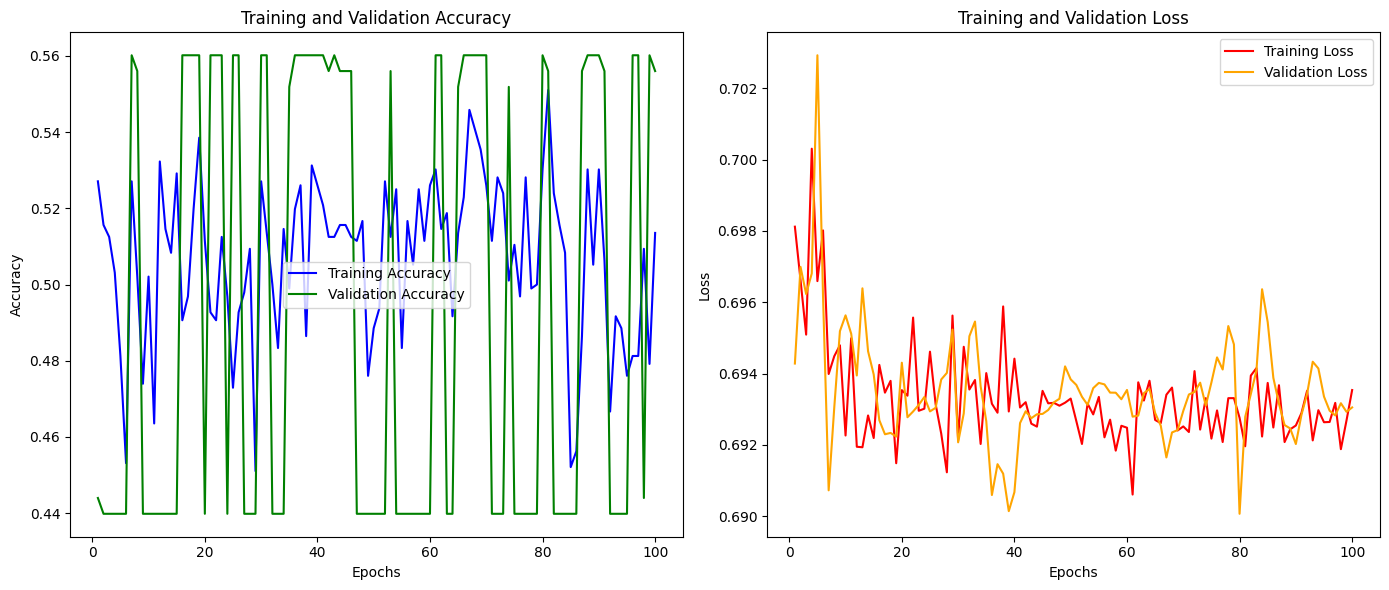

In [53]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(acc) + 1)


# Create subplots
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()